In [128]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , precision_score, recall_score , f1_score , roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import shap
import pickle
from scipy import stats


In [129]:
# Column names (from UCI documentation)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", 
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv("../data/raw/processed.cleveland.data", names=columns)

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [131]:
df.shape

(303, 14)

In [132]:
# Chec missing values
print(df.isnull().sum())


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [134]:
df.describe(include = object)

,ca,thal
count,303,303
unique,5,4
top,0.0,3.0
freq,176,166


In [135]:
catcols2 = df.select_dtypes( include = ['object']).columns
for col in catcols2:
    unique_vals = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_vals)
    print('-' * 40)

Unique values in 'ca':
['0.0' '3.0' '2.0' '1.0' '?']
----------------------------------------
Unique values in 'thal':
['6.0' '3.0' '7.0' '?']
----------------------------------------


In [64]:
print((df == "?").sum()) 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [136]:
df.replace("?", np.nan, inplace=True)

In [137]:
print((df == "?").sum()) 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [138]:
df2 = df.copy()

In [139]:
# Fill missing values with mode
for col in ["ca", "thal"]:
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\bhava\AppData\Local\Temp\ipykernel_23180\3851474926.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [10]:
df["thal"].value_counts()

thal
3.0    168
7.0    117
6.0     18
Name: count, dtype: int64

C:\Users\bhava\AppData\Local\Temp\ipykernel_23180\2365786561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["target"] , palette = "coolwarm")


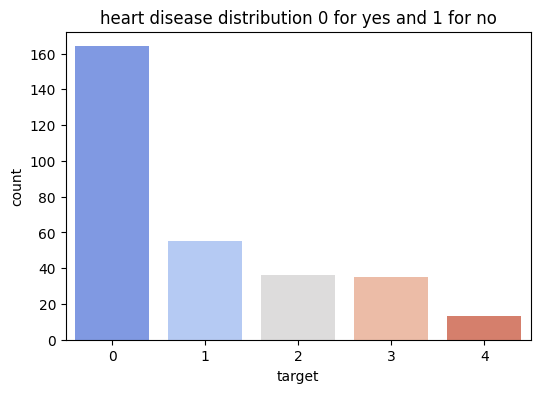

In [11]:
plt.figure(figsize = (6,4))
sns.countplot(x = df["target"] , palette = "coolwarm") 
plt.title("heart disease distribution 0 for yes and 1 for no")
plt.show()

In [141]:
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

C:\Users\bhava\AppData\Local\Temp\ipykernel_23180\2365786561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["target"] , palette = "coolwarm")


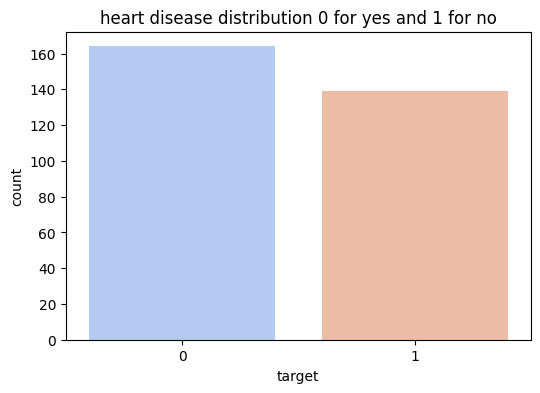

In [110]:
plt.figure(figsize = (6,4))
sns.countplot(x = df["target"] , palette = "coolwarm") 
plt.title("heart disease distribution 0 for yes and 1 for no")
plt.show()

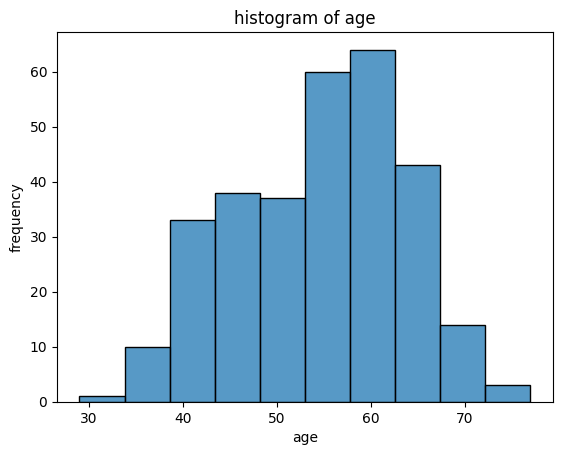

In [11]:
sns.histplot(df['age'], bins=10, kde=False)
plt.xlabel('age')
plt.ylabel('frequency')
plt.title('histogram of age')
plt.show()

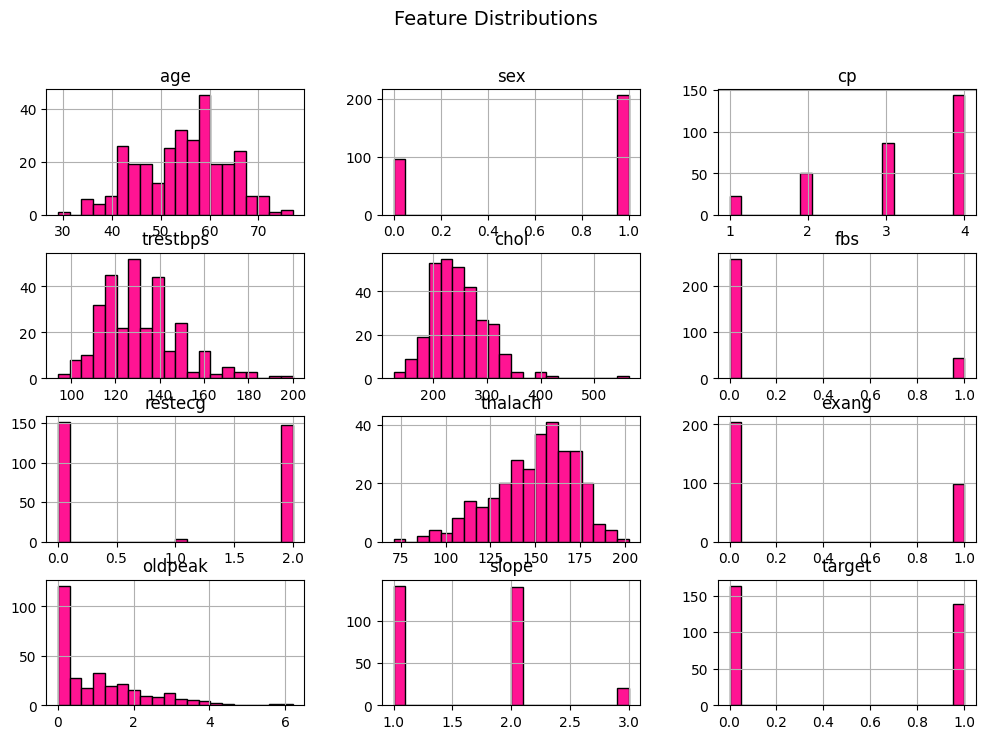

In [36]:
# Histogram for numerical features
df.hist(figsize=(12,8), bins=20, color = "deeppink" ,edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\1406004509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], data=df, palette="Set2")


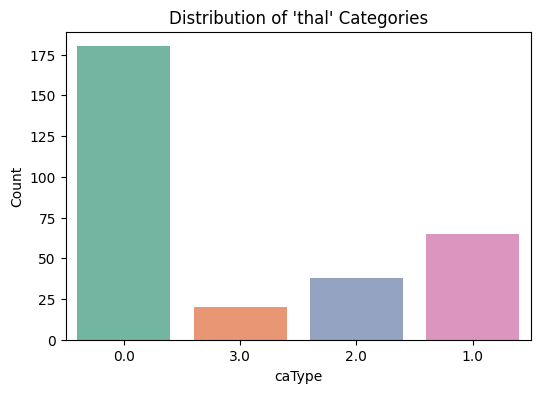

C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\1406004509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], data=df, palette="Set2")


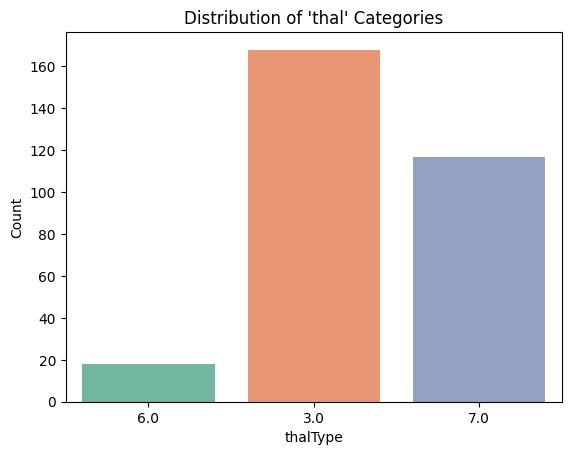

In [37]:
plt.figure(figsize=(6, 4))
for col in ["ca" , "thal"]:
    sns.countplot(x=df[col], data=df, palette="Set2")
    plt.title("Distribution of 'thal' Categories")
    plt.xlabel(col +"Type")
    plt.ylabel("Count")
    plt.show()


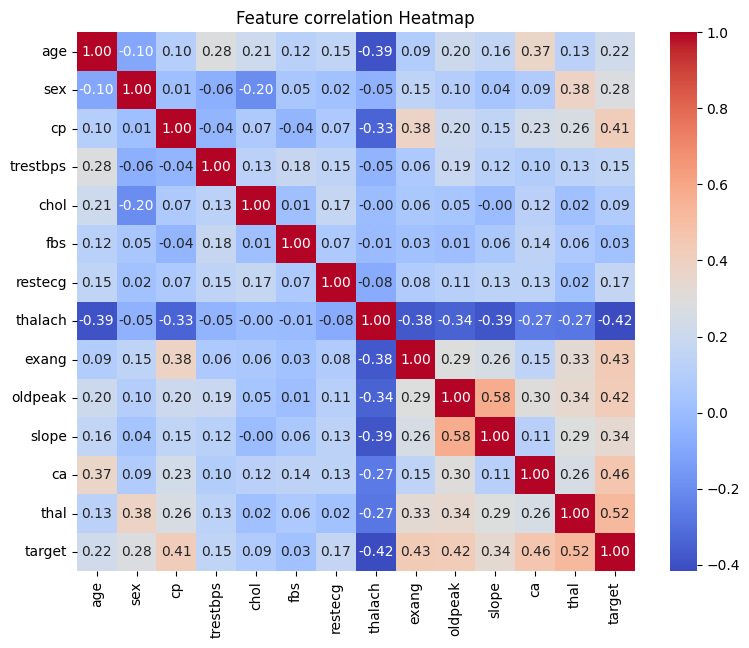

In [38]:
plt.figure(figsize = (9 , 7))
sns.heatmap(df.corr(), cmap = "coolwarm" , annot = True , fmt = ".2f")
plt.title("Feature correlation Heatmap")
plt.show()

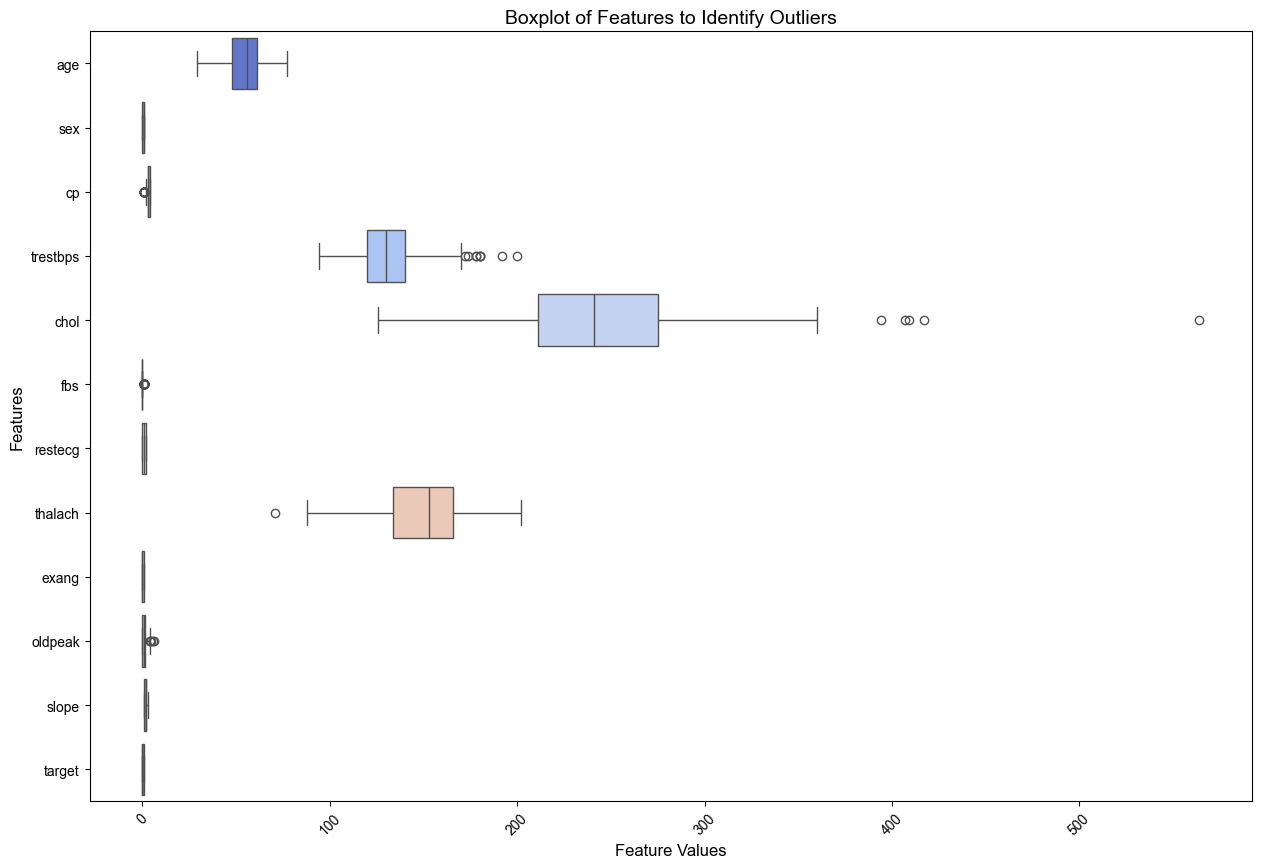

In [18]:
plt.figure(figsize=(15, 10))
# df.boxplot()
plt.xticks(rotation=45)
sns.set_style("whitegrid")
sns.boxplot(data=df, orient="h", palette="coolwarm")
plt.xlabel("Feature Values", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Boxplot of Features to Identify Outliers", fontsize=14)
plt.show()

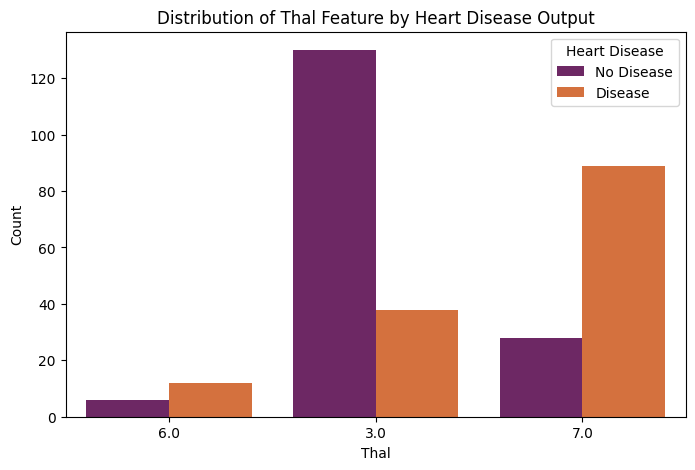

In [41]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='thal', hue='target' ,palette='inferno')
plt.title('Distribution of Thal Feature by Heart Disease Output')
plt.xlabel('Thal')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease', 'Disease'])
plt.show()

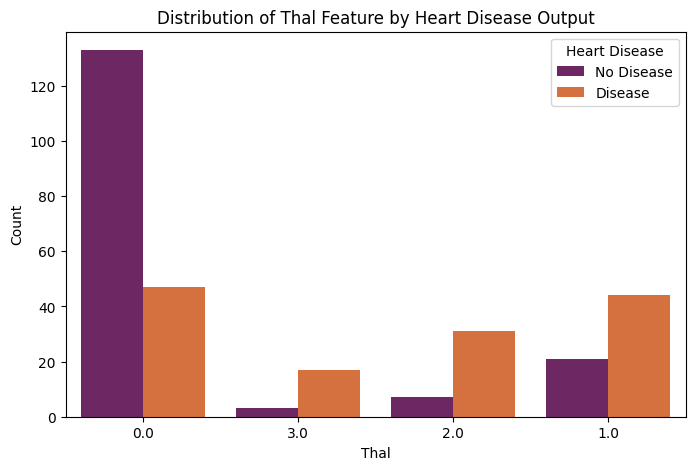

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='ca', hue='target' ,palette='inferno')
plt.title('Distribution of Thal Feature by Heart Disease Output')
plt.xlabel('Thal')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease', 'Disease'])
plt.show()

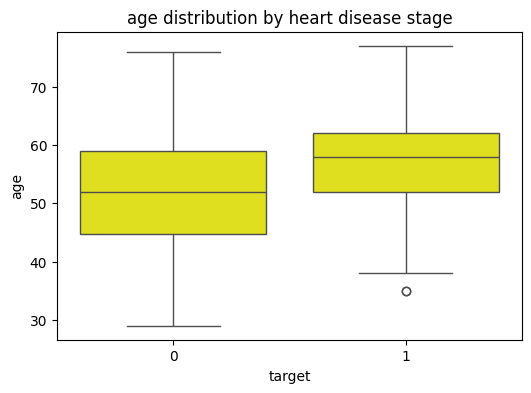

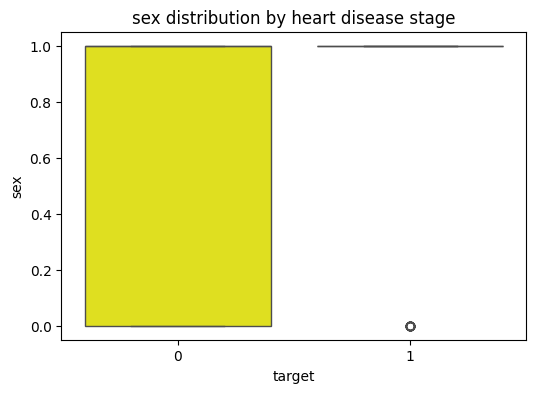

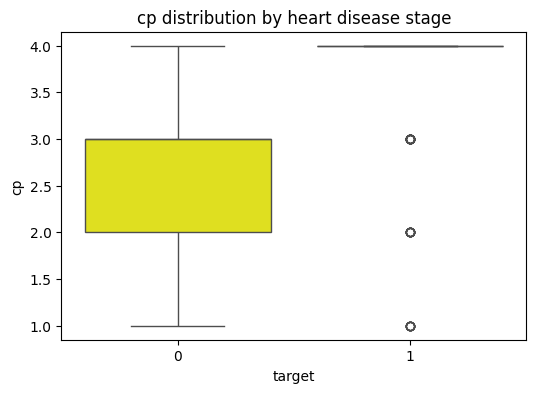

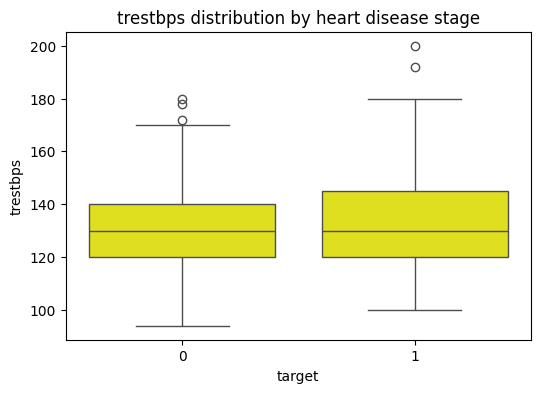

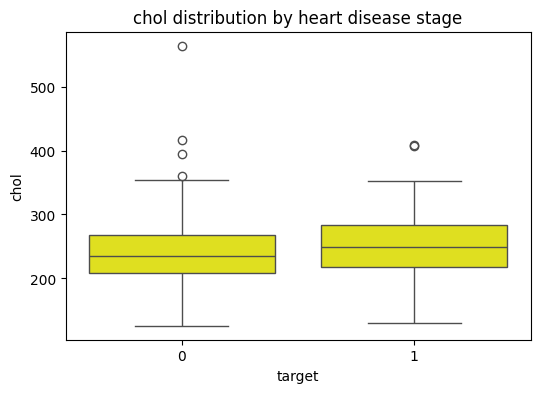

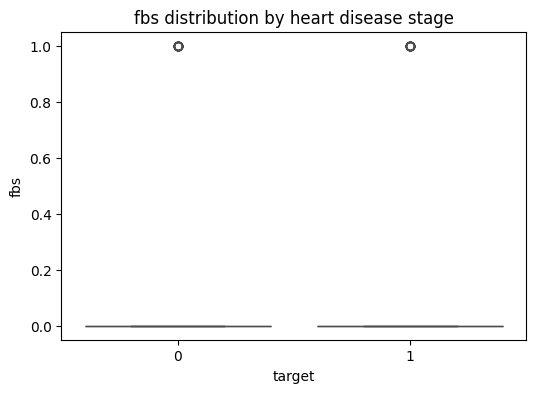

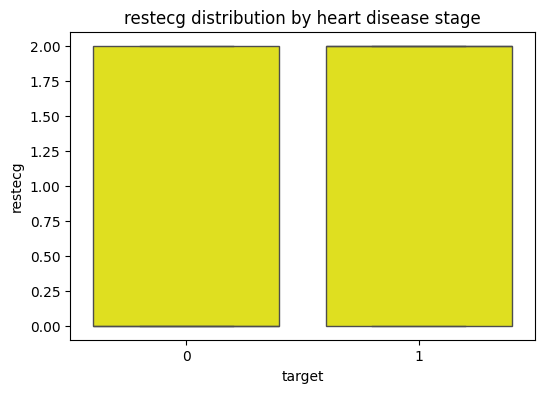

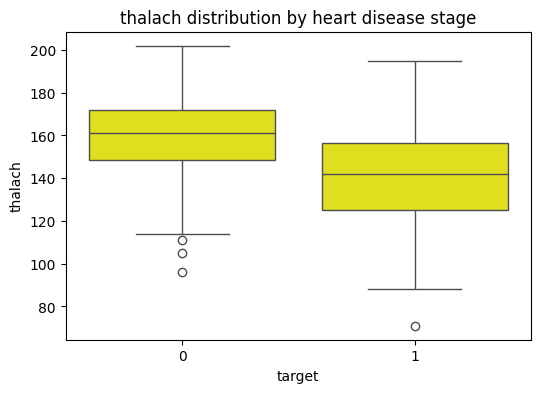

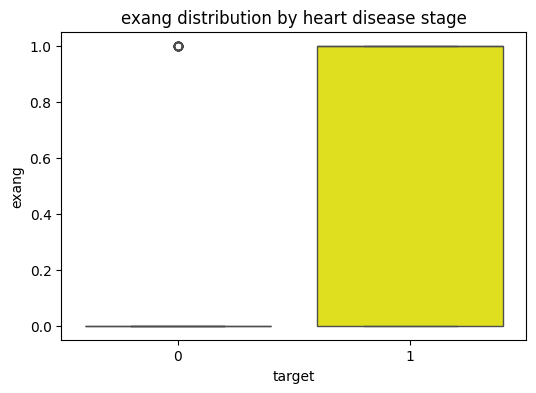

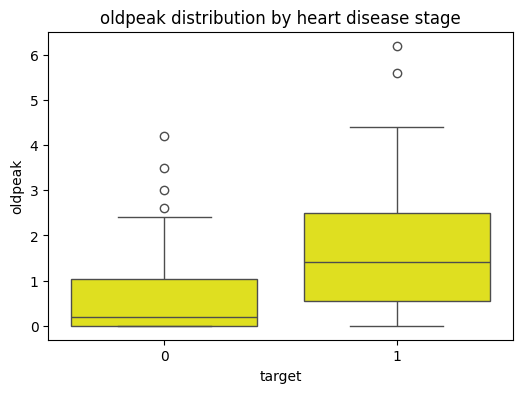

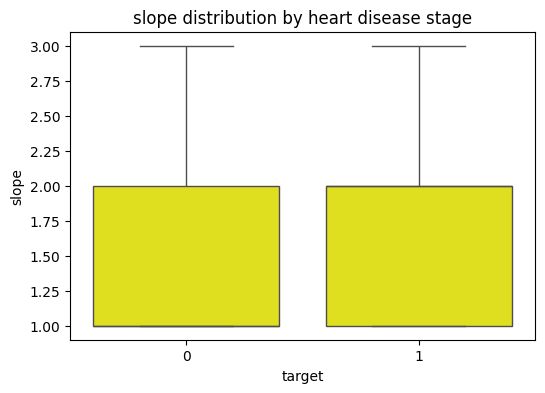

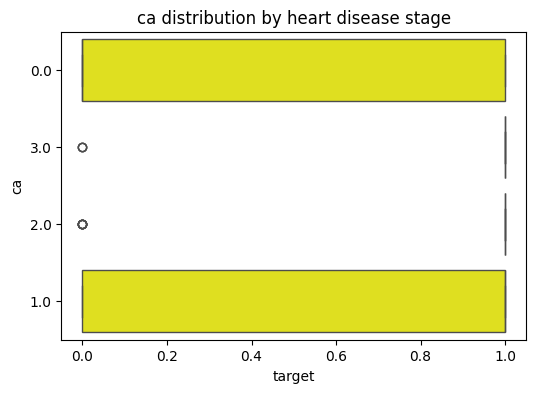

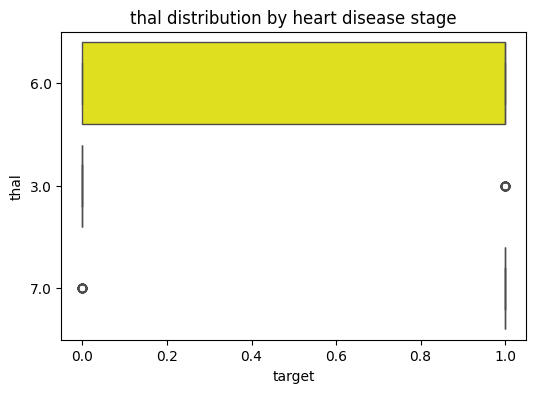

In [ ]:
for col in df.columns:
    if col != "target": 
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df["target"], y=df[col] , color = "yellow")
        plt.title(f"{col} distribution by heart disease stage")
        plt.show()


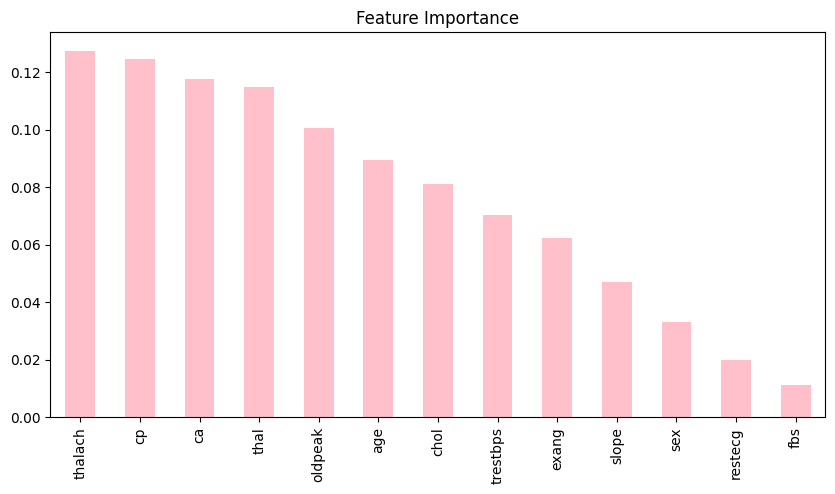

In [142]:
X = df.drop(columns=["target"])
y = df["target"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Feature Importance"  , color = 'pink')
plt.show()


In [143]:
import numpy as np

#to detect outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)  
    Q3 = np.percentile(data, 75)  
    IQR = Q3 - Q1  # IQR

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data < lower_bound) | (data > upper_bound)]

for col in df.select_dtypes(include=np.number).columns:
    outliers = detect_outliers_iqr(df[col].dropna())
    print(f"{col}: {len(outliers)} outliers")


age: 0 outliers
sex: 0 outliers
cp: 23 outliers
trestbps: 9 outliers
chol: 5 outliers
fbs: 45 outliers
restecg: 0 outliers
thalach: 1 outliers
exang: 0 outliers
oldpeak: 5 outliers
slope: 0 outliers
target: 0 outliers


In [44]:
print(df['cp'].value_counts())


cp
4.0    144
3.0     86
2.0     50
1.0     23
Name: count, dtype: int64


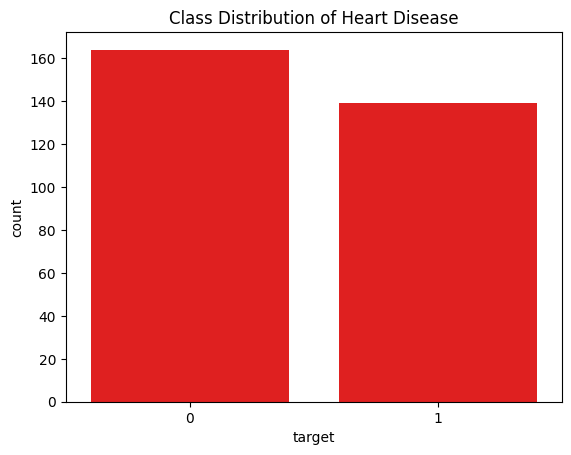

In [53]:
sns.countplot(x=df["target"]  , color= 'red')
plt.title("Class Distribution of Heart Disease")
plt.show()


In [46]:
target = df['target'].value_counts(normalize=True) * 100
print(target)

target
0    54.125413
1    45.874587
Name: proportion, dtype: float64


In [145]:
z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))

# to find outlires
outliers = (z_scores > 3).sum(axis=0)
print("Outlier conts per feature:\n", outliers)


Outlier conts per feature:
 age         0
sex         0
cp          0
trestbps    2
chol        4
fbs         0
restecg     0
thalach     1
exang       0
oldpeak     2
slope       0
target      0
dtype: int64


In [56]:
df.select_dtypes(include=["object"]).head()

,ca,thal
0,0.0,6.0
1,3.0,3.0
2,2.0,7.0
3,0.0,3.0
4,0.0,3.0


In [146]:
# Convert thal and ca to integer
df['thal'] = df['thal'].astype(float).astype(int)
df['ca'] = df['ca'].astype(float).astype(int)

# one-hot encoding
df = pd.get_dummies(df, columns=['thal', 'ca'], drop_first=True)


In [112]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target,thal_6,thal_7,ca_1,ca_2,ca_3
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,True,False,False,False,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,1,False,False,False,False,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1,False,True,False,True,False
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0,False,False,False,False,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,False,False,False,False,False


In [147]:
cat_features = [ "restecg", "slope" ] #, "thal" , "ca" ]
df = pd.get_dummies(df, columns=cat_features, drop_first=True)


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   thalach      303 non-null    float64
 7   exang        303 non-null    float64
 8   oldpeak      303 non-null    float64
 9   target       303 non-null    int64  
 10  thal_6       303 non-null    bool   
 11  thal_7       303 non-null    bool   
 12  ca_1         303 non-null    bool   
 13  ca_2         303 non-null    bool   
 14  ca_3         303 non-null    bool   
 15  restecg_1.0  303 non-null    bool   
 16  restecg_2.0  303 non-null    bool   
 17  slope_2.0    303 non-null    bool   
 18  slope_3.0    303 non-null    bool   
dtypes: bool(

In [148]:
scaler = StandardScaler()
num_features = ["age", "chol", "thalach", "trestbps" , "oldpeak"]  
df[num_features] = scaler.fit_transform(df[num_features])

In [149]:
df.to_csv('../data/processed/cleandata.csv', index = False)

In [150]:
scaler = StandardScaler()
num_features = [ "oldpeak"]  
df[num_features] = scaler.fit_transform(df[num_features])

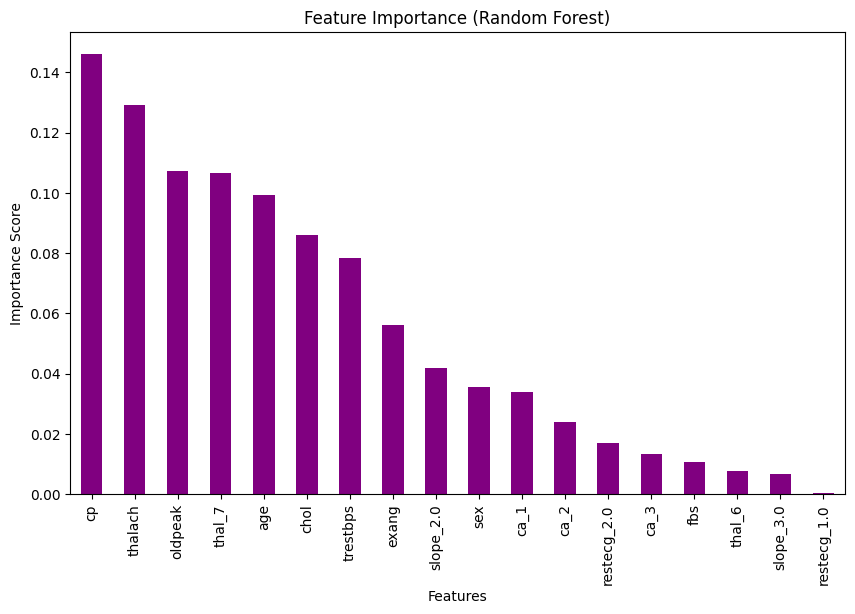

In [151]:
#  X , y 
X = df.drop(columns=["target"]) 
y = df["target"]

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)


feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
feature_importance.plot(kind="bar", color="purple")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [152]:
X = df.drop(columns =['target'])
y = df['target']
X_train , X_test , y_train , y_test = train_test_split(X, y , random_state = 42 , test_size = 0.20 , stratify = y )


In [153]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


Accuracy: 0.8852
Precision: 0.8387
(important metric here)Recall (Sensitivity): 0.9286
F1 Score: 0.8814
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



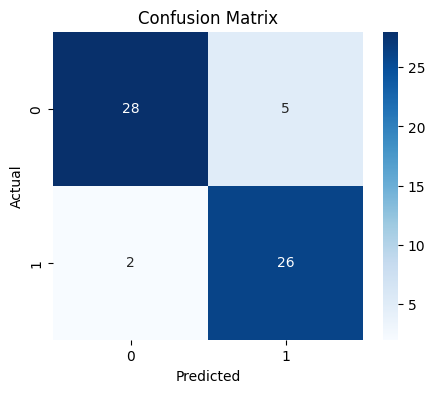

In [154]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_prob[:,1])
print(f"Precision: {precision:.4f}")
print(f"(important metric here)Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#confsuion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


C:\Users\bhava\AppData\Local\Temp\ipykernel_23180\892460987.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="inferno")


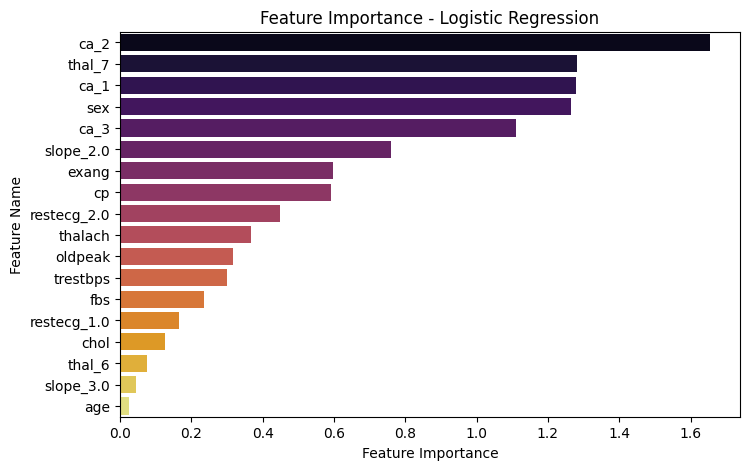

In [155]:
#absolute mean importance across all classes
feature_importance = np.mean(np.abs(model.coef_), axis=0)

importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="inferno")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance - Logistic Regression")
plt.show()

In [156]:
df1 = df.drop(columns = ['chol'])

In [157]:
X = df1.drop(columns =['target'])
y = df1['target']

Accuracy: 0.8852
Precision: 0.8387
(important metric here)Recall (Sensitivity): 0.9286
F1 Score: 0.8814
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



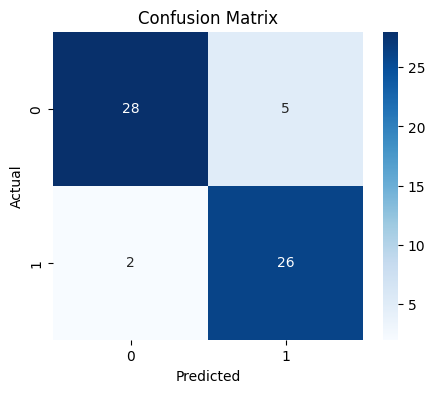

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X, y , random_state = 42 , test_size = 0.20 , stratify = y )

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"(important metric here)Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#confsuion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [159]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

#train & evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name}: Accuracy = {acc:.2f}, Precision = {prec:.2f}, Recall = {rec:.2f}, F1 Score = {f1:.2f}")


Logistic Regression: Accuracy = 0.89, Precision = 0.84, Recall = 0.93, F1 Score = 0.88
Random Forest: Accuracy = 0.90, Precision = 0.84, Recall = 0.96, F1 Score = 0.90
XGBoost: Accuracy = 0.84, Precision = 0.78, Recall = 0.89, F1 Score = 0.83
[LightGBM] [Info] Number of positive: 111, number of negative: 131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458678 -> initscore=-0.165667
[LightGBM] [Info] Start training from score -0.165667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
# no chol 
# with log transform  adn no scaling   no scaling . no modelling -1  
# Logistic Regression: Accuracy = 0.85, Precision = 0.81, Recall = 0.89, F1 Score = 0.85
# Random Forest: Accuracy = 0.90, Precision = 0.84, Recall = 0.96, F1 Score = 0.90
# XGBoost: Accuracy = 0.84, Precision = 0.78, Recall = 0.89, F1 Score = 0.83

# with log transfomr and scaling  - 2
# Logistic Regression: Accuracy = 0.87, Precision = 0.81, Recall = 0.93, F1 Score = 0.87
# Random Forest: Accuracy = 0.92, Precision = 0.85, Recall = 1.00, F1 Score = 0.92
# XGBoost: Accuracy = 0.84, Precision = 0.78, Recall = 0.89, F1 Score = 0.83

# with no log transform .. but do scaling  - 3
# Logistic Regression: Accuracy = 0.89, Precision = 0.84, Recall = 0.93, F1 Score = 0.88
# Random Forest: Accuracy = 0.92, Precision = 0.85, Recall = 1.00, F1 Score = 0.92
# XGBoost: Accuracy = 0.84, Precision = 0.78, Recall = 0.89, F1 Score = 0.83
# LightGBM: Accuracy = 0.82, Precision = 0.74, Recall = 0.93, F1 Score = 0.83

# with 'chol'  feature also  , there is no huge difference . infact the scores reduced for LR for 1 ,2 , but remianed same for 3 

# when age was removed 
# Logistic Regression: Accuracy = 0.89, Precision = 0.84, Recall = 0.93, F1 Score = 0.88
# Random Forest: Accuracy = 0.85, Precision = 0.81, Recall = 0.89, F1 Score = 0.85
# XGBoost: Accuracy = 0.85, Precision = 0.85, Recall = 0.82, F1 Score = 0.84
# LightGBM: Accuracy = 0.82, Precision = 0.79, Recall = 0.82, F1 Score = 0.81
# 


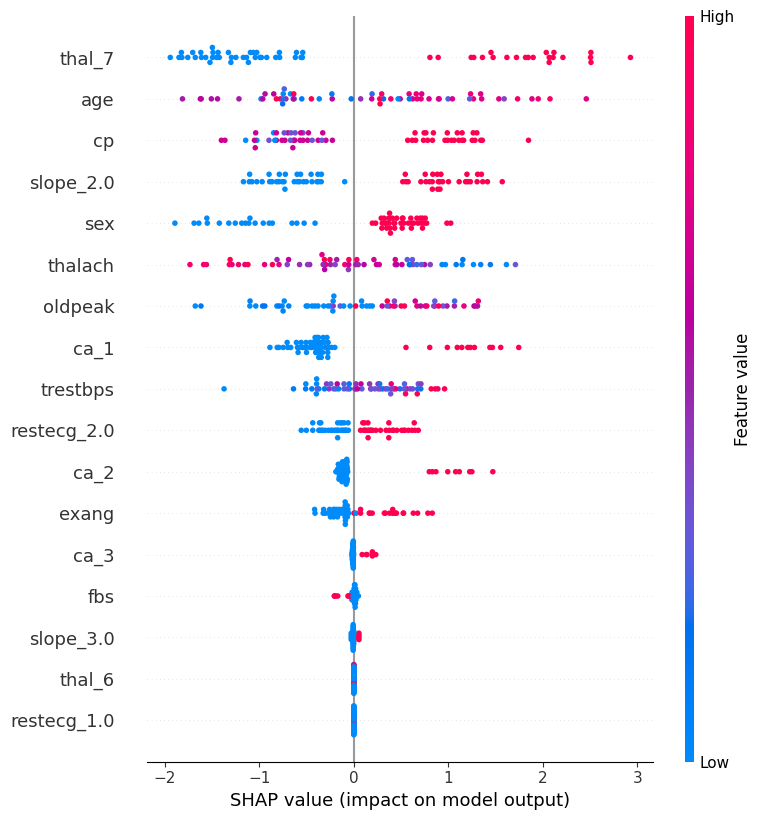

In [160]:
# Explaining XGBoost Model
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


<Figure size 640x480 with 0 Axes>

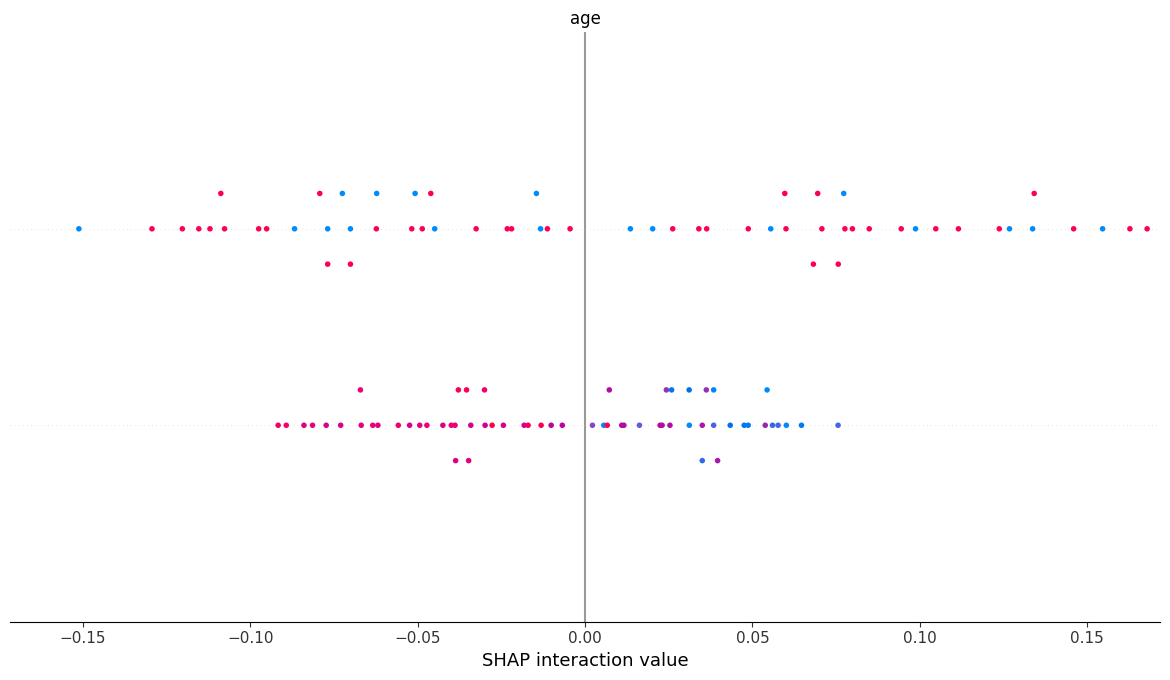

In [172]:
# Explaining Random Forest Model
explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(X_test , check_additivity=False)
shap.summary_plot(shap_values, X_test)


In [173]:
# LR tuning to just check 
log_reg = LogisticRegression(solver='liblinear') 

log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2']  
}

grid_log_reg = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_log_reg.fit(X_train, y_train)

print(f"Best Logistic Regression Params: {grid_log_reg.best_params_}")
print(f"Best Logistic Regression Accuracy: {grid_log_reg.best_score_:.4f}")

# RF tuning
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}


grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best Random Forest Params: {grid_rf.best_params_}")
print(f"Best Random Forest Accuracy: {grid_rf.best_score_:.4f}")



Best Logistic Regression Params: {'C': 10, 'penalty': 'l1'}
Best Logistic Regression Accuracy: 0.8263
Best Random Forest Params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Accuracy: 0.8054


In [174]:
#evaluating
best_log_reg = grid_log_reg.best_estimator_
best_rf = grid_rf.best_estimator_

log_reg_test_acc = best_log_reg.score(X_test, y_test)
rf_test_acc = best_rf.score(X_test, y_test)

print(f"Logistic Regression Test Accuracy: {log_reg_test_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")


Logistic Regression Test Accuracy: 0.8689
Random Forest Test Accuracy: 0.8852


In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Baseline Models for comparision
# SVM Model - Linear Kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)

svm_linear_acc = accuracy_score(y_test, y_pred_linear)
print(f"SVM (Linear) Test Accuracy: {svm_linear_acc:.4f}")


SVM (Linear) Test Accuracy: 0.8525


In [176]:
#RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

svm_rbf.fit(X_train, y_train)

y_pred_svm = svm_rbf.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM (RBF Kernel) Test Accuracy: {svm_accuracy:.4f}")


SVM (RBF Kernel) Test Accuracy: 0.9016


In [177]:
#Saving best model and preprocessing
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Numeric Transformer: Median Imputation + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Mode Imputation + One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Full Pipeline: Preprocessing + Logistic Regression Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

In [178]:
X = df2.drop(columns=['target'])
y = df2['target']

model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('classifier', RandomForestClassifier())])

In [179]:
import pickle

with open("heart_disease_pipeline.pkl", "wb") as file:
    pickle.dump(model_pipeline, file)